# Predicting Loan Defaults

##### Aim: Help LendingClub, an online loan provider, to understand  who is likely to default and who they should lend to in the future.
------------------------
## Plan for predictive analysis - classification to predict the defaulter
 
#### A. Pre-modeling (data processing) 
1. import libraries


2. data import and exploration (summary statistics, vizualizations) 


3. data cleaning:
    - drop features (columns) with more than 50% of values missing,
    - drop features that only get populated once a loan has been granted (as model only inputs data for a new applicant)
    - drop features containing just one constant value,
    - drop categorical features showing high cardinality (= too many levels) that are not needed for machine learning and such as not worth further manipulation (eg. "binning")
    - drop observations (rows) with missing values
    - "regex" operations on Python object values (eg. get rid of '%' symbol)
    - transform data types where needed (eg. str -> float)
    - drop observations related to current loans (as model only inputs data for a new applicant)


4. feauture engineering:
    - set target variable "loan_status" as binary (0 = default, 1 = paid)
    - "binning" categorical features - lower the cardinality by binning values into eg. quartile intervals (results into just 4 levels and data less affected by outliers)
    - apply Box-cox transformation to address skeweness (make variables distribution more normal)

    
5. feature selection:
    - train/test split first to avoid overfitting!
    - on train and test datasets separatelly:
        - perform further feature reduction 
            - based on correlation (between features, and between features and target variable)
            - based on variation
            

6. feature dummying
	- dummy categorical variables (models can only handle numerical features)
	

#### B. Model building - machine learning binary classification model for prediction of loan default: Logistic regression, Decision Tree, Random Forest
- target variable: loan_status (binary variable)
- feature matrix (explanatory variables): all features engineered and selected in the pre-modeling step
- null model for cross validation
- build models on default classification threshold 0.5 (Logistic regression, Decision Tree, Random Forest)
- access model performance 
    - calculate metrics: accuracy, precision, sensitivity (= recall), specificity, AUC
    - visualize ROC
- visualize sensitivity and specificity graphs by modifying the classification threshold and find the optimal threshold
- compare the predictive power of adjusted models (TP and TN on confusion matrices) and choose the best model

#### C. Exploratory data analysis
- conclude with listing out which are the main features that have direct and clear impact on an applicant being likely to pay the loan or fall into default
- showcase model application on random sample of loan applicants

# A. Pre-modeling

## 1 Import Libraries

In [1]:
# pandas and numpy for data manipulation
import numpy as np
import pandas as pd

# remove scientific notation
pd.options.display.float_format = '{:.2f}'.format

In [2]:
# vizualizations
import matplotlib.pyplot as plt
import seaborn as sns

## 2 Data import and Exploration

In [3]:
## data import and date types specification
data = pd.read_csv("data/lending_club_loans.csv", 
                   dtype={36: float, 
                         48: str,
                         "term": str                        
                         })

# print first 5 observations (with all the columns) 
pd.set_option('display.max_columns', None)
data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501.00,1296599.00,5000.00,5000.00,4975.00,36 months,10.65%,162.87,B2,NaN,10+ years,RENT,24000.00,Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I need to upgrade...,credit_card,Computer,860xx,AZ,27.65,0.00,Jan-1985,735.00,739.00,1.00,nan,nan,3.00,0.00,13648.00,83.7%,9.00,0.00,0.00,0.00,5863.16,5833.84,5000.00,863.16,0.00,0.00,0.00,Jan-2015,171.62,NaN,Sep-2016,744.00,740.00,0.00,nan,1.00,INDIVIDUAL,nan,nan,nan,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,0.00,nan,nan,nan,nan
1,1077430.00,1314167.00,2500.00,2500.00,2500.00,60 months,15.27%,59.83,C4,Ryder,< 1 year,RENT,30000.00,Source Verified,Dec-2011,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I plan to use thi...,car,bike,309xx,GA,1.00,0.00,Apr-1999,740.00,744.00,5.00,nan,nan,3.00,0.00,1687.00,9.4%,4.00,0.00,0.00,0.00,1008.71,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-2013,119.66,NaN,Sep-2016,499.00,0.00,0.00,nan,1.00,INDIVIDUAL,nan,nan,nan,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,0.00,nan,nan,nan,nan
2,1077175.00,1313524.00,2400.00,2400.00,2400.00,36 months,15.96%,84.33,C5,NaN,10+ years,RENT,12252.00,Not Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,real estate business,606xx,IL,8.72,0.00,Nov-2001,735.00,739.00,2.00,nan,nan,2.00,0.00,2956.00,98.5%,10.00,0.00,0.00,0.00,3005.67,3005.67,2400.00,605.67,0.00,0.00,0.00,Jun-2014,649.91,NaN,Sep-2016,719.00,715.00,0.00,nan,1.00,INDIVIDUAL,nan,nan,nan,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,0.00,nan,nan,nan,nan
3,1076863.00,1277178.00,10000.00,10000.00,10000.00,36 months,13.49%,339.31,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.00,Source Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/21/11 > to pay for proper...,other,person

In [4]:
# get size of the data set
data.shape

(42538, 114)

In [5]:
# see data types of all features
data.dtypes.to_dict()

{'id': dtype('float64'),
 'member_id': dtype('float64'),
 'loan_amnt': dtype('float64'),
 'funded_amnt': dtype('float64'),
 'funded_amnt_inv': dtype('float64'),
 'term': dtype('O'),
 'int_rate': dtype('O'),
 'installment': dtype('float64'),
 'sub_grade': dtype('O'),
 'emp_title': dtype('O'),
 'emp_length': dtype('O'),
 'home_ownership': dtype('O'),
 'annual_inc': dtype('float64'),
 'verification_status': dtype('O'),
 'issue_d': dtype('O'),
 'loan_status': dtype('O'),
 'pymnt_plan': dtype('O'),
 'url': dtype('O'),
 'desc': dtype('O'),
 'purpose': dtype('O'),
 'title': dtype('O'),
 'zip_code': dtype('O'),
 'addr_state': dtype('O'),
 'dti': dtype('float64'),
 'delinq_2yrs': dtype('float64'),
 'earliest_cr_line': dtype('O'),
 'fico_range_low': dtype('float64'),
 'fico_range_high': dtype('float64'),
 'inq_last_6mths': dtype('float64'),
 'mths_since_last_delinq': dtype('float64'),
 'mths_since_last_record': dtype('float64'),
 'open_acc': dtype('float64'),
 'pub_rec': dtype('float64'),
 'revo

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42538 entries, 0 to 42537
Columns: 114 entries, id to total_il_high_credit_limit
dtypes: float64(92), object(22)
memory usage: 37.0+ MB


In [7]:
# summary statistics for each column
data.describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
count,42535.00,42535.00,42535.00,42535.00,42535.00,42535.00,42531.00,42535.00,42506.00,42535.00,42535.00,42506.00,15609.00,3651.00,42506.00,42506.00,42535.00,42506.00,42538.00,42535.00,42535.00,42535.00,42535.00,42535.00,42535.00,42535.00,42535.00,42535.00,42535.00,42535.00,42535.00,42390.00,0.00,42535.00,0.00,0.00,0.00,42506.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,42390.00,42506.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,41170.00,42430.00,0.00,0.00,0.00,0.00
mean,664579.85,825702.55,11089.72,10821.59,10139.83,322.62,69136.56,13.37,0.15,713.05,717.05,1.08,35.02,59.18,9.34,0.06,14297.86,22.12,0.00,11.85,11.82,12005.64,11298.59,9664.27,2239.55,1.52,100.31,13.96,2612.72,689.31,676.38,0.00,nan,1.00,nan,nan,nan,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,0.14,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.05,0.00,nan,nan,nan,nan
std,219302.22,279540.91,7410.94,7146.91,7131.69,208.93,64096.35,6.73,0.51,36.19,36.19,1.53,22.42,47.15,4.50,0.25,22018.44,11.59,0.01,125.38,125.06,9067.24,9010.32,7087.47,2583.72,7.83,718.08,159.62,4385.20,80.20,119.01,0.00,nan,0.00,nan,nan,nan,0.01,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,29.36,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.21,0.00,nan,nan,nan,nan
min,54734.00,70473.00,500.00,500.00,0.00,15.67,1896.00,0.00,0.00,610.00,614.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,nan,1.00,nan,nan,nan,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,0.00,nan,nan,nan,nan
25%,498392.50,638479.50,5200.00,5000.00,4950.00,165.52,40000.00,8.20,0.00,685.00,689.00,0.00,17.00,0.00,6.00,0.00,3635.00,13.00,0.00,0.00,0.00,5462.79,4791.41,4400.00,657.10,0.00,0.00,0.00,211.37,644.00,640.00,0.00,nan,1.00,nan,nan,nan,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,0.00,nan,nan,nan,nan
50%,644250.00,824178.00,9700.00,9600.00,8500.00,277.69,59000.00,13.47,0.00,710.00,714.00,1.00,33.00,85.00,9.00,0.00,8821.00,20.00,0.00,0.00,0.00

In [8]:
## missing values

# function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'missing_values', 1 : '%_of_total_values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '%_of_total_values', ascending=False).round(1)
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

# save it as a new DataFrame
features_with_mis_val = missing_values_table(data)

# convert row names into column
features_with_mis_val.index.name = 'feature_name'
features_with_mis_val.reset_index(inplace = True)

# print the first 50 observations
features_with_mis_val.head(60)

,feature_name,missing_values,%_of_total_values
0,dti_joint,42538,100.00
1,annual_inc_joint,42538,100.00
2,mo_sin_old_rev_tl_op,42538,100.00
3,mo_sin_old_il_acct,42538,100.00
4,bc_util,42538,100.00
5,bc_open_to_buy,42538,100.00
6,avg_cur_bal,42538,100.00
7,acc_open_past_24mths,42538,100.00
8,inq_last_12m,42538,100.00
9,total_cu_tl,42538,100.00


In [9]:
# close look into number of levels of categorical variables
for col_name in data.columns:
    if data[col_name].dtypes == 'object':
        unique_cat = len(data[col_name].unique()) - 1
        print("'{col_name}' : {unique_cat} unique categories".format(
                col_name = col_name, unique_cat = unique_cat))

'term' : 2 unique categories
'int_rate' : 394 unique categories
'sub_grade' : 35 unique categories
'emp_title' : 30446 unique categories
'emp_length' : 11 unique categories
'home_ownership' : 5 unique categories
'verification_status' : 3 unique categories
'issue_d' : 55 unique categories
'loan_status' : 9 unique categories
'pymnt_plan' : 2 unique categories
'url' : 42535 unique categories
'desc' : 28948 unique categories
'purpose' : 14 unique categories
'title' : 20969 unique categories
'zip_code' : 837 unique categories
'addr_state' : 50 unique categories
'earliest_cr_line' : 530 unique categories
'revol_util' : 1119 unique categories
'last_pymnt_d' : 106 unique categories
'next_pymnt_d' : 101 unique categories
'last_credit_pull_d' : 111 unique categories
'application_type' : 1 unique categories


In [10]:
# take a look at the levels of outcome variable "loan_status" (current status of the loan)
print(data["loan_status"].value_counts())

Fully Paid                                             33586
Charged Off                                             5653
Does not meet the credit policy. Status:Fully Paid      1988
Does not meet the credit policy. Status:Charged Off      761
Current                                                  513
In Grace Period                                           16
Late (31-120 days)                                        12
Late (16-30 days)                                          5
Default                                                    1
Name: loan_status, dtype: int64


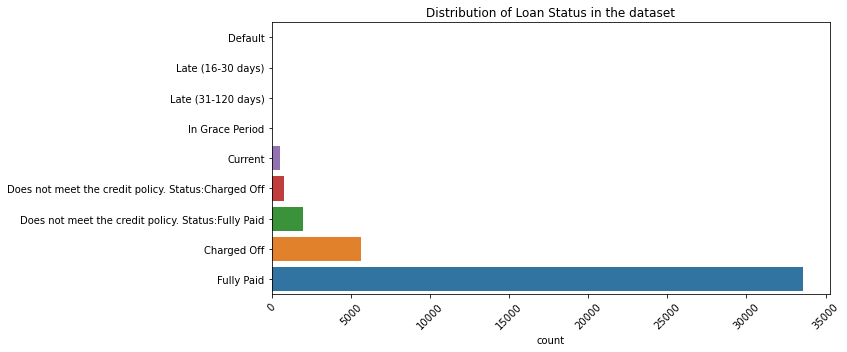

In [11]:
# visualize number of values in each level of target variable
target_var_count = data['loan_status'].value_counts()
target_var_count = target_var_count.to_frame()
target_var_count.reset_index(inplace=True)
target_var_count.columns = ['loan_status','count']

plt.subplots(figsize=(10,5))
sns.barplot(y = 'loan_status',
            x = 'count',
            data = target_var_count,
            orient = "h").invert_yaxis()
plt.xlabel("count")
plt.ylabel("")
plt.title("Distribution of Loan Status in the dataset")
plt.xticks(rotation = 45)

#plt.savefig('graphs/distribution_of_loan_status.png', dpi=100, bbox_inches='tight')

plt.show();

## 3 Data cleaning
- drop features (columns) with more than 50% of values missing,
- drop features that only get populated once a loan has been granted (as model only inputs data for a new applicant)
- drop features containing just one constant value,
- drop categorical features showing high cardinality (= too many levels) that are not needed for machine learning and such as not worth further manipulation (eg. "binning")
- drop observations (rows) with missing values
- "regex" operations on Python object values (eg. get rid of '%' symbol)
- transform data types where needed (eg. str -> float)
- drop observations related to current loans (as model only inputs data for a new applicant)

In [12]:
# get a Series of features that have more than 50% of values missing
NA_features = features_with_mis_val.loc[features_with_mis_val["%_of_total_values"] > 50].loc[:, "feature_name"].copy()

NA_features.reset_index(drop = True, inplace = True)
NA_features.shape, NA_features.head()

((57,),
 0               dti_joint
 1        annual_inc_joint
 2    mo_sin_old_rev_tl_op
 3      mo_sin_old_il_acct
 4                 bc_util
 Name: feature_name, dtype: object)

In [13]:
# drop such features from the data frame and display the new dimension
data.drop(columns = NA_features, inplace = True)

data.shape

(42538, 57)

In [14]:
# drop categorical features with just 1 level, or toooo many levels
# drop features "id" and "member_id" as those are not needed for machine learning
# drop feature "pymnt_plan" as it has two levels where one of the levels has just 1 value
# drop feature "sub_grade" as "int_rate" contains the real interest rate value
# drop feature "recoveries", "issue_d" etc. as these get populated only once a loan has been granted and is in progress
#  I have to built a model that takes as input only data that will be available for an applicant with no history with the company

data.drop(columns = ["emp_title",
                    "url",
                    "desc",
                    "title",
                    "zip_code",
                    "earliest_cr_line",
                    "last_pymnt_d",
                    "last_credit_pull_d",
                    "application_type",
                    "id",
                    "member_id",
                    "pymnt_plan",
                    "sub_grade",
                    "addr_state",
                    "recoveries",
                    "issue_d",
                    "revol_bal",
                    "revol_util",
                    "total_pymnt",
                    "total_pymnt_inv",
                    "total_rec_prncp",
                    "last_pymnt_amnt",
                    "out_prncp",
                    "out_prncp_inv",
                    "total_rec_int",
                    "total_rec_late_fee",
                    "collection_recovery_fee",
                    "collections_12_mths_ex_med",
                    "chargeoff_within_12_mths",
                    "delinq_amnt",
                    "initial_list_status",
                    "inq_last_6mths",
                    "total_acc",
                    "last_fico_range_high",
                    "last_fico_range_low"],
                    #"fico_range_high",
                    #"fico_range_low"], 
                     inplace = True)

data.shape

(42538, 22)

In [15]:
# print all remaining features
data.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'loan_status', 'purpose', 'dti', 'delinq_2yrs',
       'fico_range_low', 'fico_range_high', 'open_acc', 'pub_rec',
       'policy_code', 'acc_now_delinq', 'pub_rec_bankruptcies', 'tax_liens'],
      dtype='object')

In [16]:
# "int_rate"
# remove '%' from "int_rate"
data['int_rate'] = data['int_rate'].str[:-1].astype(float)

data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,dti,delinq_2yrs,fico_range_low,fico_range_high,open_acc,pub_rec,policy_code,acc_now_delinq,pub_rec_bankruptcies,tax_liens
0,5000.00,5000.00,4975.00,36 months,10.65,162.87,10+ years,RENT,24000.00,Verified,Fully Paid,credit_card,27.65,0.00,735.00,739.00,3.00,0.00,1.00,0.00,0.00,0.00
1,2500.00,2500.00,2500.00,60 months,15.27,59.83,< 1 year,RENT,30000.00,Source Verified,Charged Off,car,1.00,0.00,740.00,744.00,3.00,0.00,1.00,0.00,0.00,0.00
2,2400.00,2400.00,2400.00,36 months,15.96,84.33,10+ years,RENT,12252.00,Not Verified,Fully Paid,small_business,8.72,0.00,735.00,739.00,2.00,0.00,1.00,0.00,0.00,0.00
3,10000.00,10000.00,10000.00,36 months,13.49,339.31,10+ years,RENT,49200.00,Source Verified,Fully Paid,other,20.00,0.00,690.00,694.00,10.00,0.00,1.00,0.00,0.00,0.00
4,3000.00,3000.00,3000.00,60 months,12.69,67.79,1 year,RENT,80000.00,Source Verified,Current,other,17.94,0.00,695.00,699.00,15.00,0.00,1.00,0.00,0.00,0.00


In [17]:
# drop observations (rows) from feature "pub_rec_bankruptcies" and "emp_length" that have missing values
# as imputing these would potentionally lead to biasing my train data for machine learning purpose
data = data[data["pub_rec_bankruptcies"].notnull()]
data = data[data["emp_length"].notnull()]

data.shape

(40058, 22)

In [18]:
# check missing values are all gone as models can't cope with NA - OK!
data.isna().sum()

loan_amnt               0
funded_amnt             0
funded_amnt_inv         0
term                    0
int_rate                0
installment             0
emp_length              0
home_ownership          0
annual_inc              0
verification_status     0
loan_status             0
purpose                 0
dti                     0
delinq_2yrs             0
fico_range_low          0
fico_range_high         0
open_acc                0
pub_rec                 0
policy_code             0
acc_now_delinq          0
pub_rec_bankruptcies    0
tax_liens               0
dtype: int64

In [19]:
# "loan_status" - target variable
# filter "Current", "In Grace Period", both "Late.." and "Default" observations
# note. Does not meet the credit policy. Status:Fully Paid - googled: credit policy was updated after this loan was listed but before it issued
data = data.loc[(data["loan_status"].isin(["Fully Paid", "Charged Off"]))].copy()

print(data["loan_status"].value_counts())

Fully Paid     32180
Charged Off     5305
Name: loan_status, dtype: int64


In [20]:
# assign cleaned data to new object 
data_clean = data.copy()

## 4 Feature engineering
- set target variable "loan_status" as binary (0 = default, 1 = paid)
- "binning" categorical features (lowering the cardinality, eg. by binning values into quartile intervals results into just 4 levels and data less affected by outliers)
- apply Box-cox transformation to address skeweness (make variables distribution more normal)

In [21]:
# make outcome variable binary: assign 1 if loan "Fully Paid", 0 if "Charged Off"
# predicting whether a person defaulted their loan or not. 0 means they deaulted and 1 means they paid off their loan
data_clean.loc[:, "loan_status"] = np.where(data_clean["loan_status"] == "Fully Paid", 1, 0)

# print values counts -> imbalanced data set
print(data_clean["loan_status"].value_counts())

1    32180
0     5305
Name: loan_status, dtype: int64


In [22]:
# "delinq_2yrs"

# convert float to categorical
data_clean["delinq_2yrs"] = data_clean["delinq_2yrs"].astype('category')

# binning categorical values
def label_delinq (row):
    if row['delinq_2yrs'] == 0.00:
        return '0'
    if row['delinq_2yrs'] == 1.00:
        return '1'
    return '2+'

data_clean['delinq_2yrs'] = data_clean.apply(lambda row: label_delinq(row), axis=1)

# print updated categories and number of values in each category
print(data_clean["delinq_2yrs"].value_counts())

0     33421
1      3121
2+      943
Name: delinq_2yrs, dtype: int64


In [23]:
# "pub_rec"

# convert float to categorical
data_clean["pub_rec"] = data_clean["pub_rec"].astype('category')

# binning categorical values
def label_pub_rec (row):
    if row['pub_rec'] == 0.00:
        return '0'
    return '1+'

data_clean['delinq_2yrs'] = data_clean.apply(lambda row: label_pub_rec(row), axis=1)

# print updated categories and number of values in each category
print(data_clean["delinq_2yrs"].value_counts())

0     35522
1+     1963
Name: delinq_2yrs, dtype: int64


In [24]:
# "pub_rec_bankruptcies"

# convert int to categorical
data_clean["pub_rec_bankruptcies"] = data_clean["pub_rec_bankruptcies"].astype('category')

# binning categorical values
def label_pub_rec_bankruptcies (row):
    if row['pub_rec_bankruptcies'] == 0.00:
        return '0'
    return '1+'

data_clean['pub_rec_bankruptcies'] = data_clean.apply(lambda row: label_pub_rec_bankruptcies(row), axis=1)

# print updated categories and number of values in each category
print(data_clean["pub_rec_bankruptcies"].value_counts())

0     35923
1+     1562
Name: pub_rec_bankruptcies, dtype: int64


In [25]:
# "open_acc"

# produce a Categorical object indicating quartile membership for each data point
bin_labels_open_acc = ['1st quartile', '2nd quartile', '3rd quartile', '4th quartile']

data_clean['open_acc_quartile'] = pd.qcut(data_clean['open_acc'],
                                                  q = [0, .25, .5, .75, 1],
                                                  labels = bin_labels_open_acc)

# drop the two original feature
data_clean.drop(columns = ["open_acc"], inplace = True)

print(data_clean["open_acc_quartile"].value_counts())

2nd quartile    11067
1st quartile    10831
3rd quartile     7814
4th quartile     7773
Name: open_acc_quartile, dtype: int64


In [26]:
# "fico_range_high" and "fico_range_low"

# create new feature "fico_range" as an average of these two
data_clean["fico_range"] = (data_clean["fico_range_high"] + data_clean["fico_range_low"]) / 2

# drop the two features
data_clean.drop(columns = ["fico_range_high",
                          "fico_range_low"], inplace = True)

In [27]:
data_clean.shape

(37485, 21)

In [28]:
data_clean.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,dti,delinq_2yrs,pub_rec,policy_code,acc_now_delinq,pub_rec_bankruptcies,tax_liens,open_acc_quartile,fico_range
0,5000.00,5000.00,4975.00,36 months,10.65,162.87,10+ years,RENT,24000.00,Verified,1,credit_card,27.65,0,0.00,1.00,0.00,0,0.00,1st quartile,737.00
1,2500.00,2500.00,2500.00,60 months,15.27,59.83,< 1 year,RENT,30000.00,Source Verified,0,car,1.00,0,0.00,1.00,0.00,0,0.00,1st quartile,742.00
2,2400.00,2400.00,2400.00,36 months,15.96,84.33,10+ years,RENT,12252.00,Not Verified,1,small_business,8.72,0,0.00,1.00,0.00,0,0.00,1st quartile,737.00
3,10000.00,10000.00,10000.00,36 months,13.49,339.31,10+ years,RENT,49200.00,Source Verified,1,other,20.00,0,0.00,1.00,0.00,0,0.00,3rd quartile,692.00
5,5000.00,5000.00,5000.00,36 months,7.90,156.46,3 years,RENT,36000.00,Source Verified,1,wedding,11.20,0,0.00,1.00,0.00,0,0.00,2nd quartile,732.00


In [29]:
# I've significantly reduced dimension of my data set, time to get the report generated
#import pandas_profiling

#pandas_profiling.ProfileReport(data_clean)

In [30]:
# report showed some skewenes in "annual_inc" variable distribution
# apply Box-cox transformation to make all numerical variables more normally distributed
numerical = data_clean.columns[data_clean.dtypes == 'float64']

from scipy.stats import boxcox

for i in numerical:
    if data_clean[i].min() > 0 and data_clean[i].var() > 0:
        transformed, lamb = boxcox(data_clean.loc[data_clean[i].notnull(), i])
        if np.abs(1 - lamb) > 0.02:
            data_clean.loc[data_clean[i].notnull(), i] = transformed

## 5 Feature selection
- train/test split first to avoid overfitting and bias


- on train and test datasets separatelly:		
	- perform further feature reduction 
         - 5.1 based on correlation
             - 6.1.1 between features
             - 6.1.2 between features and target variable)
         - 5.2 based on variation

In [31]:
# assign X as a DataFrame of features (explanatory matrix), and y as Series (Outcome variable)
X = data_clean.drop(columns = "loan_status")
y = data_clean["loan_status"]

In [32]:
# split data into train and test
# the train-test split procedure is used to estimate the performance of machine learning algorithms when they are used to make predictions on data not used to train the model
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2) 

X_train.shape, X_test.shape

((29988, 20), (7497, 20))

In [33]:
# imbalanced data set -> stratified split into train and test (equal 1 and 0 in target variable)
#
#from sklearn.model_selection import train_test_split
#
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)

In [34]:
X_train.shape, X_test.shape

((29988, 20), (7497, 20))

In [35]:
print(y_train.value_counts())

1    25771
0     4217
Name: loan_status, dtype: int64


### 5.1. Filter features by correlation
- using Phi_K correlation coefficient based on several refinements to Pearson’s hypothesis test of independence of two variables
- Phi_K works consistently between categorical, ordinal and interval variables

#### 5.1.1 correlation between features (explanatory variables)
- assumtion for regression is that there isn't too much correlation between explanatory variables

interval columns not set, guessing: ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'policy_code', 'acc_now_delinq', 'tax_liens', 'fico_range']


/usr/local/anaconda3/lib/python3.8/site-packages/phik/data_quality.py:67: UserWarning: Not enough unique value for variable policy_code for analysis 1. Dropping this column
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/phik/data_quality.py:67: UserWarning: Not enough unique value for variable acc_now_delinq for analysis 1. Dropping this column
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/phik/data_quality.py:67: UserWarning: Not enough unique value for variable tax_liens for analysis 1. Dropping this column
  warnings.warn(


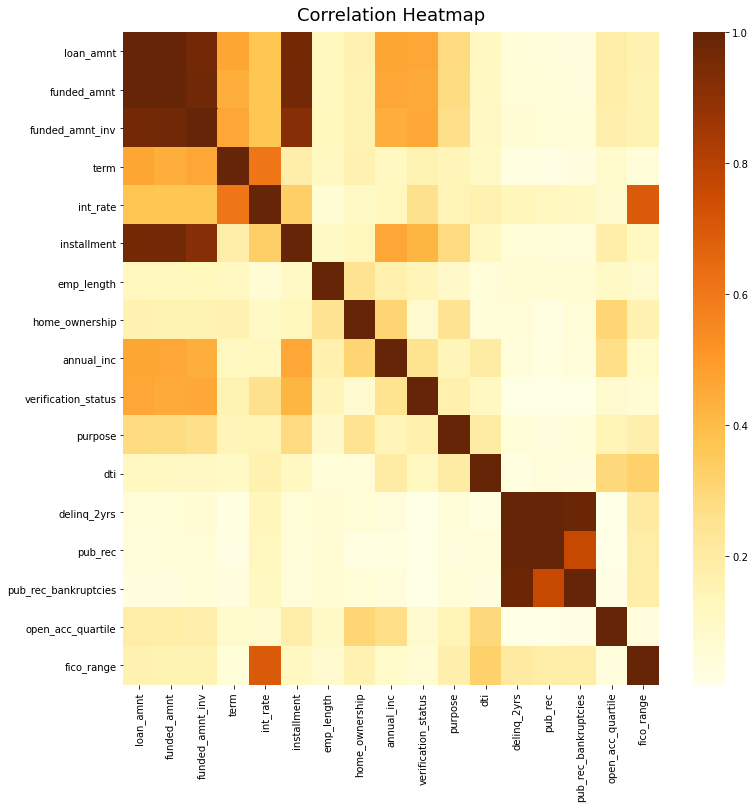

In [36]:
# so eg. if there is two features that are highly corellated (above set threshold), one should be dropped as only one is needed in the model
# it's again to prevent model overfitting

# visualize correlation with a heatmap
import phik
#ax = sns.color_palette("rocket_r", as_cmap=True)

# visualize correlation with a heatmap
fig, ax = plt.subplots()
fig.set_size_inches(12,12)
corr_heatmap = sns.heatmap(X_train.phik_matrix(), cmap = "YlOrBr");
corr_heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

#plt.savefig('graphs/heatmap_all.png', dpi=100, bbox_inches='tight')

In [37]:
# create a function that selects highly correlated features
def phik_correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.phik_matrix()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [38]:
# find features that have correlation higher than 0.9 (to keep just one of them)
corr_features = phik_correlation(X_train, 0.9)
len(set(corr_features))

interval columns not set, guessing: ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'policy_code', 'acc_now_delinq', 'tax_liens', 'fico_range']


5

In [39]:
corr_features

{'funded_amnt',
 'funded_amnt_inv',
 'installment',
 'pub_rec',
 'pub_rec_bankruptcies'}

In [40]:
# set pandas to see the whole correlation matrix
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
X_train.phik_matrix()

interval columns not set, guessing: ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'policy_code', 'acc_now_delinq', 'tax_liens', 'fico_range']


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,pub_rec,pub_rec_bankruptcies,open_acc_quartile,fico_range
loan_amnt,1.00,1.00,0.97,0.47,0.38,0.96,0.13,0.17,0.47,0.46,0.28,0.12,0.05,0.04,0.04,0.19,0.16
funded_amnt,1.00,1.00,0.97,0.44,0.37,0.97,0.13,0.16,0.46,0.45,0.28,0.11,0.05,0.04,0.04,0.19,0.15
funded_amnt_inv,0.97,0.97,1.00,0.46,0.37,0.92,0.13,0.16,0.44,0.46,0.27,0.11,0.06,0.05,0.05,0.18,0.16
term,0.47,0.44,0.46,1.00,0.61,0.18,0.11,0.16,0.12,0.15,0.14,0.10,0.02,0.01,0.03,0.09,0.05
int_rate,0.38,0.37,0.37,0.61,1.00,0.33,0.06,0.10,0.13,0.26,0.15,0.17,0.14,0.12,0.12,0.08,0.70
installment,0.96,0.97,0.92,0.18,0.33,1.00,0.11,0.13,0.46,0.42,0.28,0.12,0.05,0.04,0.04,0.18,0.11
emp_length,0.13,0.13,0.13,0.11,0.06,0.11,1.00,0.25,0.17,0.14,0.09,0.04,0.07,0.06,0.06,0.10,0.08
home_ownership,0.17,0.16,0.16,0.16,0.10,0.13,0.25,1.00,0.31,0.08,0.25,0.05,0.05,0.02,0.05,0.30,0.17
annual_inc,0.47,0.46,0.44,0.12,0.13,0.46,0.17,0.31,1.00,0.26,0.14,0.20,0.04,0.03,0.04,0.27,0.09
verification_status,0.46,0.45,0.46,0.15,0.26,0.42,0.14,0.08,0.26,1.00,0.17,0.11,0.01,0.01,0.00,0.08,0.06


In [41]:
# show correlation matrix of highly correlated features
high_corr_subset = X_train.loc[:, (
 'loan_amnt',   
 'funded_amnt',
 'funded_amnt_inv',
 'installment',
 'delinq_2yrs',
 'pub_rec',
 'pub_rec_bankruptcies')]
high_corr_subset.phik_matrix()

interval columns not set, guessing: ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'installment']


,loan_amnt,funded_amnt,funded_amnt_inv,installment,delinq_2yrs,pub_rec,pub_rec_bankruptcies
loan_amnt,1.00,1.00,0.97,0.96,0.05,0.04,0.04
funded_amnt,1.00,1.00,0.97,0.97,0.05,0.04,0.04
funded_amnt_inv,0.97,0.97,1.00,0.92,0.06,0.05,0.05
installment,0.96,0.97,0.92,1.00,0.05,0.04,0.04
delinq_2yrs,0.05,0.05,0.06,0.05,1.00,1.00,0.98
pub_rec,0.04,0.04,0.05,0.04,1.00,1.00,0.77
pub_rec_bankruptcies,0.04,0.04,0.05,0.04,0.98,0.77,1.00


interval columns not set, guessing: ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'installment']


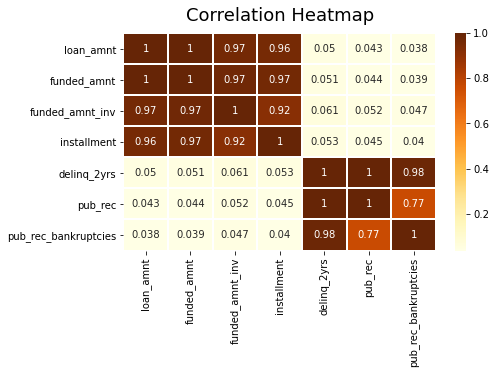

In [42]:
# visualize correlation of highly correlated (> 0.9) features with heatmap 
fig, ax = plt.subplots()
fig.set_size_inches(7,4)
high_corr_heatmap = sns.heatmap(high_corr_subset.phik_matrix(), cmap = "YlOrBr", annot = True, linewidth=1, linecolor="white")
high_corr_heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

#plt.savefig('graphs/heatmap_sub.png', dpi=100, bbox_inches='tight')

In [43]:
# drop features that are highly correlated (keep just one features from each correlation "cluster")
X_train = X_train.drop(columns = corr_features)
X_test = X_test.drop(columns = corr_features)

X_train.shape, X_test.shape

((29988, 15), (7497, 15))

In [44]:
X_train.head()

,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,policy_code,acc_now_delinq,tax_liens,open_acc_quartile,fico_range
37281,38.78,36 months,4.17,< 1 year,MORTGAGE,8.00,Source Verified,home_improvement,4.69,0,1.00,0.00,0.00,4th quartile,0.26
18393,35.77,60 months,4.52,3 years,MORTGAGE,7.51,Not Verified,car,12.25,0,1.00,0.00,0.00,2nd quartile,0.26
16915,34.60,36 months,5.94,6 years,RENT,7.45,Source Verified,debt_consolidation,14.03,0,1.00,0.00,0.00,2nd quartile,0.26
29884,40.80,60 months,6.24,2 years,RENT,7.33,Source Verified,credit_card,14.78,1+,1.00,0.00,0.00,2nd quartile,0.26
3390,33.32,36 months,5.77,6 years,MORTGAGE,7.74,Verified,credit_card,13.47,0,1.00,0.00,0.00,4th quartile,0.26


#### 5.2.2. correlation between features and outcome (explanatory variables and target)
- another assumption for regression is also that there is some correlation between explanatory variables and target variable

In [45]:
# temporary concatenate this numerical subset of X_train data frame with y_train series
temp_concat_X_y = pd.concat([X_train, y_train], axis = 1)

#temp_concat_X_y.shape

In [46]:
# there are some 0 correlations but those  
abs(temp_concat_X_y.phik_matrix()["loan_status"]).reset_index(name = "corr_with_target").sort_values("corr_with_target", ascending = False).head(60)

interval columns not set, guessing: ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'policy_code', 'acc_now_delinq', 'tax_liens', 'fico_range', 'loan_status']


/usr/local/anaconda3/lib/python3.8/site-packages/phik/data_quality.py:67: UserWarning: Not enough unique value for variable policy_code for analysis 1. Dropping this column
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/phik/data_quality.py:67: UserWarning: Not enough unique value for variable acc_now_delinq for analysis 1. Dropping this column
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/phik/data_quality.py:67: UserWarning: Not enough unique value for variable tax_liens for analysis 1. Dropping this column
  warnings.warn(


,index,corr_with_target
12,loan_status,1.00
2,int_rate,0.27
1,term,0.25
11,fico_range,0.17
7,purpose,0.13
5,annual_inc,0.09
9,delinq_2yrs,0.09
0,loan_amnt,0.09
8,dti,0.06
4,home_ownership,0.03


In [47]:
# drop feature "open_acc_quartile" as it has very low correlation with target variable and such as would explain much in the model
X_train = X_train.drop(columns = "open_acc_quartile")
X_test = X_test.drop(columns = "open_acc_quartile")

X_train.shape, X_test.shape

((29988, 14), (7497, 14))

### 5.1. Filter features by variation
- drop features that are constant

In [48]:
# first let's look at the variance in my train data set
numerical = X_train.columns[X_train.dtypes == 'float64']

X_train_numerical = X_train.loc[:, numerical]
X_train_numerical.var()
#numerical.var()

loan_amnt        51.28
int_rate          1.25
annual_inc        0.06
dti              44.03
policy_code       0.00
acc_now_delinq    0.00
tax_liens         0.00
fico_range        0.00
dtype: float64

In [49]:
# feature selector that removes all zero-variance features (i. e. features that only contain one constant)
# note. this feature selection algorithm looks only at the features (X), not the desired outputs (y)
from sklearn.feature_selection import VarianceThreshold

var_thres = VarianceThreshold(threshold = 0)
var_thres.fit(X_train_numerical)

VarianceThreshold(threshold=0)

In [50]:
# generate boolean vector where 'False' are the features with zero-variance and such as need to be removed
var_thres.get_support()

array([ True,  True,  True,  True, False, False, False,  True])

In [51]:
# pull out those features that are "False" and count them (list comprehensions syntax)
constant_columns = [column for column in X_train_numerical.columns
                   if column not in X_train_numerical.columns[var_thres.get_support()]]

print(len(constant_columns))

3


In [52]:
# print out zero-variance features
for features in constant_columns:
    print(features)

policy_code
acc_now_delinq
tax_liens


In [53]:
# and drop them from both train and test feature matrices
X_train = X_train.drop(columns = constant_columns)
X_test = X_test.drop(columns = constant_columns)

X_train.shape, X_test.shape

((29988, 11), (7497, 11))

In [54]:
# print all remaining features
print(X_train.columns)

Index(['loan_amnt', 'term', 'int_rate', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'purpose', 'dti', 'delinq_2yrs',
       'fico_range'],
      dtype='object')


In [55]:
# I've significantly reduced dimension of my data set, time to get the report generated
#import pandas_profiling

#pandas_profiling.ProfileReport(X_train)

## 6 Feature dummying
- dummying categorical variables (models can only handle numerical features)

In [56]:
## dummying
X_train = pd.get_dummies(X_train, drop_first = True)
X_test = pd.get_dummies(X_test, drop_first = True)

X_train.head()

,loan_amnt,int_rate,annual_inc,dti,fico_range,term_60 months,emp_length_10+ years,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,emp_length_6 years,emp_length_7 years,emp_length_8 years,emp_length_9 years,emp_length_< 1 year,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,delinq_2yrs_1+
37281,38.78,4.17,8.00,4.69,0.26,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
18393,35.77,4.52,7.51,12.25,0.26,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16915,34.60,5.94,7.45,14.03,0.26,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
29884,40.80,6.24,7.33,14.78,0.26,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3390,33.32,5.77,7.74,13.47,0.26,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [57]:
X_train.shape, X_test.shape

((29988, 35), (7497, 35))

# B. Model building
1. Logistic Regression 
2. Naive Bayes
3. Decission Tree and Random Forest

In [58]:
# pipelines - a way to create more reproducible and transportable code
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler, RobustScaler

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, classification_report, roc_curve

# pipeline for Logistic Regression with Standard Scaler
logreg_ss_pipe = Pipeline([ 
    ('ss', StandardScaler()), # use standard scaler to scale X_train set to train model
    ('logreg_ss', LogisticRegression()) # create object of class LogReg
])

# pipeline for Logistic Regression with Robust Scaler
logreg_rs_pipe = Pipeline([
    ('rs', RobustScaler()),
    ('logreg_rs', LogisticRegression())
])

# pipeline for Naive Bayes
NB_pipe = Pipeline([
    ('nb', GaussianNB())
])

## 1 Logistic Regression 
- 1.1 Standard Scaler
- 1.2 Robust Scaler

In [59]:
# look at the means of features
X_train.mean().head(), X_train.mean().tail()

(loan_amnt    36.32
 int_rate      4.95
 annual_inc    7.60
 dti          13.33
 fico_range    0.26
 dtype: float64,
 purpose_renewable_energy   0.00
 purpose_small_business     0.05
 purpose_vacation           0.01
 purpose_wedding            0.02
 delinq_2yrs_1+             0.05
 dtype: float64)

In [60]:
# look at the standard deviation of features
X_train.std().head(), X_train.std().tail()

(loan_amnt    7.16
 int_rate     1.12
 annual_inc   0.25
 dti          6.64
 fico_range   0.00
 dtype: float64,
 purpose_renewable_energy   0.05
 purpose_small_business     0.21
 purpose_vacation           0.09
 purpose_wedding            0.15
 delinq_2yrs_1+             0.22
 dtype: float64)

### 1.1 Logistic Regression with features scaled using Standard Scaler
- mean = 0, standard deviation = 1

In [61]:
# fit pipelines onto train and test sets
logreg_ss_pipe.fit(X_train, y_train)

print('Logistic Regression - Standard Scaler:', '\n \n',
      
    'Mean:', StandardScaler().fit(X_train).transform(X_train).mean(), '\n \n',
      
    'Standard Deviation:', StandardScaler().fit(X_train).transform(X_train).std(), '\n \n',
      
    'Train Score:', 
      logreg_ss_pipe.score(X_train, y_train), '\n \n',
      
    'Model Accuracy Score (i.e. trained model applied on test data set):', 
      accuracy_score(y_test, logreg_ss_pipe.predict(X_test)), '\n \n', # standardize test set using the TRAIN set means and standard deviations
                                                                       # following the general principle: anything you learn, must be learned from the model's training data
                                                                       # accuracy = [accuracy,f1-score]; ((TP + TN) / N)
    
    'AUC Score:', 
      roc_auc_score(y_true = y_test, y_score = logreg_ss_pipe.predict_proba(X_test)[:, 1]), '\n \n', # keep the probabilities of possitive class only - client paying the loan (= 1)
      
    'Confusion Matrix:', '\n',
      confusion_matrix(y_test, logreg_ss_pipe.predict(X_test)), '\n \n',
      
    'Classification report:', '\n', # precision = [weighted avg, precision]; (PPV = TP / (TP+FP)) (positive predictive value)
                                    # sensitivity = [weighted avg, recall]; (TPR = TP / (TP+FN))
                                    # specificity = (TNR = TN / (TN+FP) = 1-FPR) (true negative rate)
                                    # FPR = FP / (FP + TN)
      classification_report(y_test, logreg_ss_pipe.predict(X_test)), '\n \n',
      
    'Classification Predictions:', 
      logreg_ss_pipe.predict(X_test), '\n \n',
      
    'Probability Predictions (0 = default, 1 = paid), default threshold = 0.5:', '\n',
      logreg_ss_pipe.predict_proba(X_test), '\n \n',

    'Probability predictions for possitive class only (1 = paid), default threshold = 0.5:' '\n',
      logreg_ss_pipe.predict_proba(X_test)[:, 1]
     )

Logistic Regression - Standard Scaler: 
 
 Mean: -7.535761437818039e-07 
 
 Standard Deviation: 0.9999999999997161 
 
 Train Score: 0.8596772042150194 
 
 Model Accuracy Score (i.e. trained model applied on test data set): 0.8543417366946778 
 
 AUC Score: 0.6990869916385964 
 
 Confusion Matrix: 
 [[  14 1074]
 [  18 6391]] 
 
 Classification report: 
               precision    recall  f1-score   support

           0       0.44      0.01      0.02      1088
           1       0.86      1.00      0.92      6409

    accuracy                           0.85      7497
   macro avg       0.65      0.51      0.47      7497
weighted avg       0.80      0.85      0.79      7497
 
 
 Classification Predictions: [1 1 1 ... 1 1 1] 
 
 Probability Predictions (0 = default, 1 = paid), default threshold = 0.5: 
 [[0.04394192 0.95605808]
 [0.18629938 0.81370062]
 [0.07241402 0.92758598]
 ...
 [0.18762427 0.81237573]
 [0.05882393 0.94117607]
 [0.1414944  0.8585056 ]] 
 
 Probability predictions for

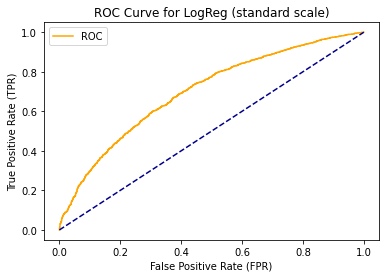

In [62]:
# now because my training data set was very imbalanced (most of the clients paid = 1) I need to find an optimum threshold to replace default one (=0.5)

# get the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, logreg_ss_pipe.predict_proba(X_test)[:, 1])

# visualize ROC
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for LogReg (standard scale)') # Receiver Operating Characteristic
plt.legend()

#plt.savefig('graphs/LR_ss_ROC.png', dpi=100, bbox_inches='tight')

plt.show()

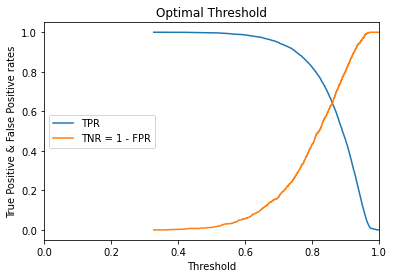

In [63]:
# visualize intercept to find optimal threshold (where the two graphs meet)
plt.plot(thresholds, tpr, label="TPR")
plt.plot(thresholds, 1 - fpr, label="TNR = 1 - FPR")
plt.legend()
plt.xlabel('Threshold')
plt.ylabel('True Positive & False Positive rates')
plt.title("Optimal Threshold")
plt.xlim(0,1);

#plt.savefig('graphs/LR_ss_opt_thres.png', dpi=100, bbox_inches='tight')

## sensitivity (= TPR; proportion of actual positives that are correctly identified)
## specificity (= TNR = 1 - FPR; proportion of actual negatives that are correctly identified)

In [64]:
# calculate optimal threshold for the model 

# finding the optimal threshold for the best accuracy of the binary classifier for imbalanced data set
# threshold used to generate point closest to the top left corner of ROC curve is the optimal one
# i.e. the optimal cut off point would be where “true positive rate” is high and the “false positive rate” is low

function = tpr + (1 - fpr)
index = np.argmax(function)

opt_thres_logreg_ss = thresholds[np.argmax(function)]
print('Optimal threshold for the binary classification:', opt_thres_logreg_ss)

Optimal threshold for the binary classification: 0.8491730850940469


In [65]:
# class prediction (0 to 1) for each observation in X_test threshold set to optimum
class_pred_test = (logreg_ss_pipe.predict_proba(X_test)[:, 1] >= opt_thres_logreg_ss).astype(int)
class_pred_test

array([1, 0, 1, ..., 0, 1, 1])

In [66]:
# confusion matrix with optimal threshold
cm_opt = confusion_matrix(y_test, class_pred_test)
cm_opt

array([[ 660,  428],
       [1996, 4413]])

In [67]:
# confusion matrix in %
cm_perc = cm_opt.astype('float')/cm_opt.sum(axis=0)
cm_perc

array([[0.24849398, 0.08841149],
       [0.75150602, 0.91158851]])

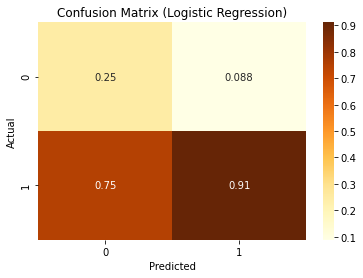

In [68]:
# visualize it
sns.heatmap(cm_perc, annot=True, cmap='YlOrBr')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Logistic Regression)");

#plt.savefig("graphs/LR_ss_cm")

### 1.2 Logistic Regression with features scaled using Robust Scaler
- check whether such model comes with similar AUC as RS deals better with data that contain outliers which I treated during feature enginering stage

In [69]:
# fit pipelines onto train and test sets
logreg_rs_pipe.fit(X_train, y_train)

print('Logistic Regrersion - Robust Scaler:', '\n \n',
      
      'Mean:', RobustScaler().fit(X_train).transform(X_train).mean(), '\n \n',
      
      'Standard Deviation:', RobustScaler().fit(X_train).transform(X_train).std(), '\n \n',
      
      'Train Score:', 
      logreg_rs_pipe.score(X_train, y_train), '\n \n',
      
      'Model Accuracy Score (i.e. trained model applied on test data set):', 
      accuracy_score(y_test, logreg_rs_pipe.predict(X_test)), '\n \n', # standardize test set using the TRAIN set means and standard deviations
      # following the general principle: anything you learn, must be learned from the model's training data
      
      'AUC Score:', 
      roc_auc_score(y_true = y_test, y_score = logreg_rs_pipe.predict_proba(X_test)[:, 1])
)

Logistic Regrersion - Robust Scaler: 
 
 Mean: 0.09204323171468493 
 
 Standard Deviation: 0.3948316264076027 
 
 Train Score: 0.8597105508870215 
 
 Model Accuracy Score (i.e. trained model applied on test data set): 0.8543417366946778 
 
 AUC Score: 0.6991427783080778


## 2 Naive Bayes

In [70]:
# fit pipelines onto train and test sets
NB_pipe.fit(X_train, y_train)

print('Naive Bayes:', '\n \n',
      
    'Train Score:', 
      NB_pipe.score(X_train, y_train), '\n \n',
      
    'Model Accuracy Score (i.e. trained model applied on test data set):', 
      accuracy_score(y_test, NB_pipe.predict(X_test)), '\n \n', # accuracy = [accuracy,f1-score]; ((TP + TN) / N)
    
    'AUC Score:', 
      roc_auc_score(y_true = y_test, y_score = NB_pipe.predict_proba(X_test)[:, 1]), '\n \n', # keep the probabilities of possitive class only - client paying the loan (= 1)
      
    'Confusion Matrix:', '\n',
      confusion_matrix(y_test, NB_pipe.predict(X_test)), '\n \n',
      
    'Classification report:', '\n', # sensitivity = [weighted avg, precision]; (TP / (TP+FN))
                                    # specificity (= weighted avg, recall) (TP / (TP+FP) 
      classification_report(y_test, NB_pipe.predict(X_test)), '\n \n',
      
    'Classification Predictions:', 
      NB_pipe.predict(X_test), '\n \n',
      
    'Probability Predictions (0 = default, 1 = paid), default threshold = 0.5:', '\n',
      NB_pipe.predict_proba(X_test), '\n \n',

    'Probability predictions for possitive class only (1 = paid), default threshold = 0.5:' '\n',
      NB_pipe.predict_proba(X_test)[:, 1]
     )

Naive Bayes: 
 
 Train Score: 0.7918167266906763 
 
 Model Accuracy Score (i.e. trained model applied on test data set): 0.7903161264505802 
 
 AUC Score: 0.6452732198746248 
 
 Confusion Matrix: 
 [[ 223  865]
 [ 707 5702]] 
 
 Classification report: 
               precision    recall  f1-score   support

           0       0.24      0.20      0.22      1088
           1       0.87      0.89      0.88      6409

    accuracy                           0.79      7497
   macro avg       0.55      0.55      0.55      7497
weighted avg       0.78      0.79      0.78      7497
 
 
 Classification Predictions: [1 1 1 ... 1 1 1] 
 
 Probability Predictions (0 = default, 1 = paid), default threshold = 0.5: 
 [[1.87665328e-03 9.98123347e-01]
 [3.14712693e-01 6.85287307e-01]
 [1.12291646e-04 9.99887708e-01]
 ...
 [2.56917635e-02 9.74308237e-01]
 [2.25161490e-02 9.77483851e-01]
 [4.09469100e-02 9.59053090e-01]] 
 
 Probability predictions for possitive class only (1 = paid), default threshold = 

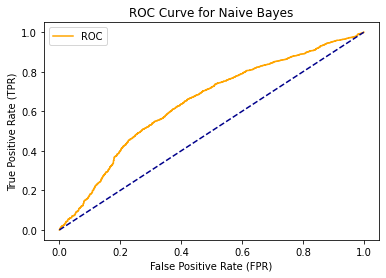

In [71]:
# get the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, NB_pipe.predict_proba(X_test)[:, 1])

# visualize ROC
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Naive Bayes') # Receiver Operating Characteristic
plt.legend()

#plt.savefig('graphs/NB_ROC.png', dpi=100, bbox_inches='tight')

plt.show()

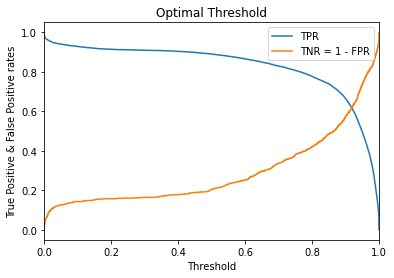

In [72]:
# visualize intercept to find optimal threshold (where the two graphs meet)
plt.plot(thresholds, tpr, label="TPR")
plt.plot(thresholds, 1 - fpr, label="TNR = 1 - FPR")
plt.legend()
plt.xlabel('Threshold')
plt.ylabel('True Positive & False Positive rates')
plt.title("Optimal Threshold")
plt.xlim(0,1);

#plt.savefig('graphs/NB_opt_thres.png', dpi=100, bbox_inches='tight')

In [73]:
# calculate optimal threshold for the model 
function = tpr + (1 - fpr)
index = np.argmax(function)

opt_thres_NB = thresholds[np.argmax(function)]
print('optimal threshold:', opt_thres_NB)

optimal threshold: 0.9019276156315349


In [74]:
# classification prediction (i. e. class 0 or 1) for each observation in X_test threshold set to optimum
class_pred_test = (NB_pipe.predict_proba(X_test)[:, 1] >= opt_thres_NB).astype(int)
class_pred_test

array([1, 0, 1, ..., 1, 1, 1])

In [75]:
cm_opt = confusion_matrix(y_test, class_pred_test)
cm_opt

array([[ 630,  458],
       [2174, 4235]])

In [76]:
cm_perc = cm_opt.astype('float')/cm_opt.sum(axis=0)
cm_perc

array([[0.22467903, 0.09759216],
       [0.77532097, 0.90240784]])

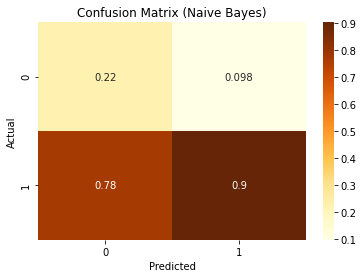

In [77]:
# visualize it
sns.heatmap(cm_perc, annot=True, cmap='YlOrBr')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Naive Bayes)");

#plt.savefig("graphs/NB_cm")

## 3 Decision Tree and Random Forest

### 3.1 Decision Tree

In [78]:
from sklearn import tree

DecTree = tree.DecisionTreeClassifier(max_depth=4)
DecTree = DecTree.fit(X_train, y_train)

print('Decision Tree:', '\n \n',
      
      'Train Score:', 
      DecTree.score(X_train, y_train), '\n \n',
      
      'Model Accuracy Score (i.e. trained model applied on test data set):', 
      accuracy_score(y_test, DecTree.predict(X_test)), '\n \n', # accuracy = [accuracy,f1-score]; ((TP + TN) / N)
      
      'AUC Score:', 
      roc_auc_score(y_true = y_test, y_score = DecTree.predict_proba(X_test)[:, 1]), '\n \n', # keep the probabilities of possitive class only - client paying the loan (= 1)
      
      'Confusion Matrix:', '\n',
      confusion_matrix(y_test, DecTree.predict(X_test)), '\n \n',
      
      'Classification report:', '\n', # sensitivity = [weighted avg, precision]; (TP / (TP+FN))
      # specificity (= weighted avg, recall) (TP / (TP+FP) 
      classification_report(y_test, DecTree.predict(X_test)), '\n \n',
      
      'Classification Predictions:', 
      DecTree.predict(X_test), '\n \n',
      
      'Probability Predictions (0 = default, 1 = paid), default threshold = 0.5:', '\n',
      DecTree.predict_proba(X_test), '\n \n',
      
      'Probability predictions for possitive class only (1 = paid), default threshold = 0.5:' '\n',
      DecTree.predict_proba(X_test)[:, 1]
)

Decision Tree: 
 
 Train Score: 0.8593770841670001 
 
 Model Accuracy Score (i.e. trained model applied on test data set): 0.854875283446712 
 
 AUC Score: 0.675654797825668 
 
 Confusion Matrix: 
 [[   0 1088]
 [   0 6409]] 
 
 Classification report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      1088
           1       0.85      1.00      0.92      6409

    accuracy                           0.85      7497
   macro avg       0.43      0.50      0.46      7497
weighted avg       0.73      0.85      0.79      7497
 
 
 Classification Predictions: [1 1 1 ... 1 1 1] 
 
 Probability Predictions (0 = default, 1 = paid), default threshold = 0.5: 
 [[0.03567937 0.96432063]
 [0.19634007 0.80365993]
 [0.03567937 0.96432063]
 ...
 [0.19634007 0.80365993]
 [0.03567937 0.96432063]
 [0.11602671 0.88397329]] 
 
 Probability predictions for possitive class only (1 = paid), default threshold = 0.5:
 [0.96432063 0.80365993 0.96432063 ... 0.80

/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


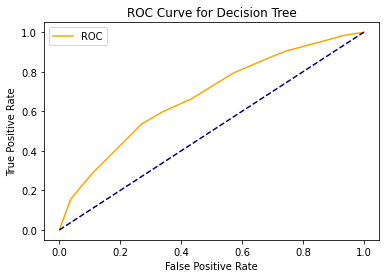

In [79]:
# get the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, DecTree.predict_proba(X_test)[:, 1])

# visualize ROC
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Decision Tree') # Receiver Operating Characteristic
plt.legend()
plt.show()

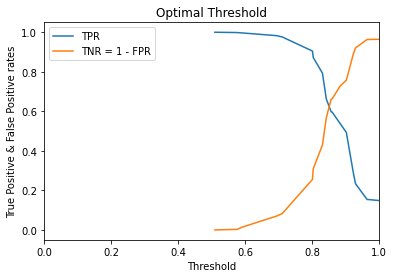

In [80]:
# visualize intercept to find optimal threshold (where the two graphs meet)
plt.plot(thresholds, tpr, label="TPR")
plt.plot(thresholds, 1 - fpr, label="TNR = 1 - FPR")
plt.legend()
plt.xlabel('Threshold')
plt.ylabel('True Positive & False Positive rates')
plt.title("Optimal Threshold")
plt.xlim(0,1);

In [81]:
# calculate optimal threshold for the model 
function = tpr + (1 - fpr)
index = np.argmax(function)

opt_thres_DT = thresholds[np.argmax(function)]
print('optimal threshold:', opt_thres_DT)

optimal threshold: 0.8839732888146912


In [82]:
# classification prediction (i. e. class 0 or 1) for each observation in X_test threshold set to optimum
class_pred_test = (DecTree.predict_proba(X_test)[:, 1] >= opt_thres_DT).astype(int)
class_pred_test

array([1, 0, 1, ..., 0, 1, 1])

In [83]:
cm_opt = confusion_matrix(y_test, class_pred_test)
cm_opt

array([[ 792,  296],
       [2962, 3447]])

In [84]:
cm_perc = cm_opt.astype('float')/cm_opt.sum(axis=0)
cm_perc

array([[0.21097496, 0.07908095],
       [0.78902504, 0.92091905]])

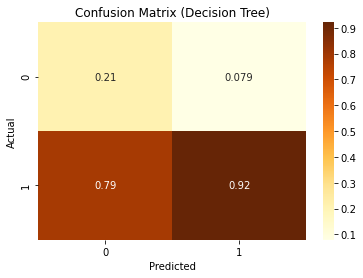

In [85]:
# visualize it
sns.heatmap(cm_perc, annot=True, cmap='YlOrBr')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Decision Tree)");

In [86]:
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz
import graphviz
 
dot_data = export_graphviz(DecTree, filled=True, rounded=True,
                                    feature_names=X_test.columns,
                                    class_names=y_test.name,
                                    out_file=None)
graph = graphviz.Source(dot_data)

# save it
#graph = graph_from_dot_data(dot_data)
#graph.write_png('graphs/tree.png')

### 2.2 Random Forest
- utilizes bootstraping to generate defined amount of Decision Trees

In [87]:
from sklearn.ensemble import RandomForestClassifier

RandFor = RandomForestClassifier(n_estimators = 500)
RandFor = RandFor.fit(X_train, y_train)

print('Random Forest:', '\n \n',
      
      'Train Score:', 
      RandFor.score(X_train, y_train), '\n \n',
      
      'Model Accuracy Score (i.e. trained model applied on test data set):', 
      accuracy_score(y_test, RandFor.predict(X_test)), '\n \n', # accuracy = [accuracy,f1-score]; ((TP + TN) / N)
      
      'AUC Score:', 
      roc_auc_score(y_true = y_test, y_score = RandFor.predict_proba(X_test)[:, 1]), '\n \n', # keep the probabilities of possitive class only - client paying the loan (= 1)
      
      'Confusion Matrix:', '\n',
      confusion_matrix(y_test, RandFor.predict(X_test)), '\n \n',
      
      'Classification report:', '\n', # sensitivity = [weighted avg, precision]; (TP / (TP+FN))
      # specificity (= weighted avg, recall) (TP / (TP+FP) 
      classification_report(y_test, RandFor.predict(X_test)), '\n \n',
      
      'Classification Predictions:', 
      RandFor.predict(X_test), '\n \n',
      
      'Probability Predictions (0 = default, 1 = paid), default threshold = 0.5:', '\n',
      RandFor.predict_proba(X_test), '\n \n',
      
      'Probability predictions for possitive class only (1 = paid), default threshold = 0.5:' '\n',
      RandFor.predict_proba(X_test)[:, 1]
)

Random Forest: 
 
 Train Score: 1.0 
 
 Model Accuracy Score (i.e. trained model applied on test data set): 0.851140456182473 
 
 AUC Score: 0.6637186734188136 
 
 Confusion Matrix: 
 [[  17 1071]
 [  45 6364]] 
 
 Classification report: 
               precision    recall  f1-score   support

           0       0.27      0.02      0.03      1088
           1       0.86      0.99      0.92      6409

    accuracy                           0.85      7497
   macro avg       0.57      0.50      0.47      7497
weighted avg       0.77      0.85      0.79      7497
 
 
 Classification Predictions: [1 1 1 ... 1 1 1] 
 
 Probability Predictions (0 = default, 1 = paid), default threshold = 0.5: 
 [[0.072 0.928]
 [0.178 0.822]
 [0.158 0.842]
 ...
 [0.274 0.726]
 [0.044 0.956]
 [0.218 0.782]] 
 
 Probability predictions for possitive class only (1 = paid), default threshold = 0.5:
 [0.928 0.822 0.842 ... 0.726 0.956 0.782]


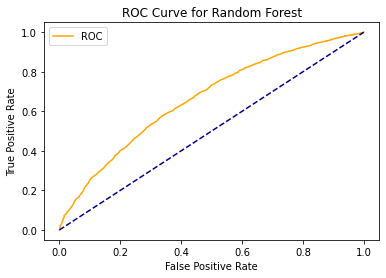

In [88]:
# get the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, RandFor.predict_proba(X_test)[:, 1])

# visualize ROC
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest') # Receiver Operating Characteristic
plt.legend()

#plt.savefig('graphs/RF_ROC.png', dpi=100, bbox_inches='tight')

plt.show()

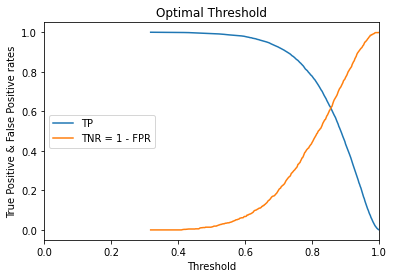

In [89]:
# visualize intercept to find optimal threshold (where the two graphs meet)
plt.plot(thresholds, tpr, label="TP")
plt.plot(thresholds, 1 - fpr, label="TNR = 1 - FPR")
plt.legend()
plt.xlabel('Threshold')
plt.ylabel('True Positive & False Positive rates')
plt.title("Optimal Threshold")
plt.xlim(0,1);

#plt.savefig('graphs/RF_opt_thres.png', dpi=100, bbox_inches='tight')

In [90]:
# calculate optimal threshold for the model 
function = tpr + (1 - fpr)
index = np.argmax(function)

opt_thres_RF = thresholds[np.argmax(function)]

In [91]:
# classification prediction (i. e. class 0 or 1) for each observation in X_test threshold set to optimum
class_pred_test = (RandFor.predict_proba(X_test)[:, 1] >= opt_thres_RF).astype(int)
class_pred_test

array([1, 0, 0, ..., 0, 1, 0])

In [92]:
cm = confusion_matrix(y_test, class_pred_test)
cm

array([[ 723,  365],
       [2726, 3683]])

In [93]:
cm_perc = cm.astype('float')/cm.sum(axis=0)
cm_perc

array([[0.20962598, 0.09016798],
       [0.79037402, 0.90983202]])

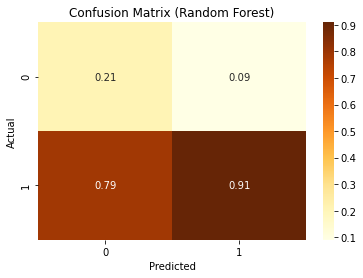

In [94]:
# visualize it
sns.heatmap(cm_perc, annot=True, cmap='YlOrBr')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Random Forest)");

#plt.savefig("graphs/RF_cm")

## C Exploratory data analysis
- list out which are the main features that have direct and clear impact on applicant being likely to pay the loan or fall into default
- showcase model application on random sample of loan applicants

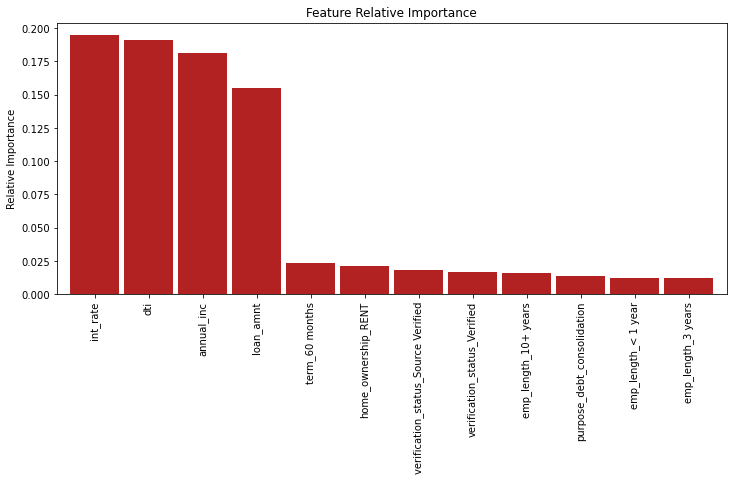

In [95]:
rel_imp = pd.DataFrame(columns=['Feature','Importance'])
rel_imp['Feature'] = feat_labels = X_test.columns
rel_imp['Importance'] = RandFor.feature_importances_
rel_imp.set_index(rel_imp['Feature'], inplace=True)
ax = rel_imp.sort_values('Importance', ascending=False)[:12].plot.bar(color='firebrick', width=0.9, legend=False, figsize=(12,5))
ax.set_xlabel('')
ax.set_ylabel('Relative Importance')
ax.set_title("Feature Relative Importance");

#ax.figure.savefig('graphs/feature_rel_importance.png', bbox_inches = "tight")

## Model showcase

In [96]:
# pick 10 random observations (client) from the test set and make prediction
# compare predicted class with the actual class
concat_test = pd.concat([y_test, X_test], axis = 1)
client_sample = concat_test.sample(10)
client_sample

,loan_status,loan_amnt,int_rate,annual_inc,dti,fico_range,term_60 months,emp_length_10+ years,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,emp_length_6 years,emp_length_7 years,emp_length_8 years,emp_length_9 years,emp_length_< 1 year,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,delinq_2yrs_1+
36232,0,30.27,6.91,7.55,22.59,0.26,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
15293,1,28.39,5.31,7.35,20.86,0.26,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
24927,1,41.27,6.70,7.53,16.08,0.26,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
10161,1,38.78,5.93,7.96,12.25,0.26,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
20691,1,36.85,2.69,7.45,6.60,0.26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
5425,0,44.69,6.12,7.86,21.87,0.26,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
11220,1,35.77,4.59,7.65,10.64,0.26,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
24979,1,30.94,3.39,7.53,15.84,0.26,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
28928,1,28.39,5.69,7.48,10.05,0.26,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
27717,1,36.85,3.67,7.65,13.98,0.26,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [97]:
# assign X as a DataFrame of features (explanatory matrix), and y as Series (Outcome variable)
X_sample = client_sample.drop(columns = "loan_status")
y_sample = client_sample["loan_status"]

In [98]:
## LogReg (standard scaler)

# fit pipelines onto train and test sets
logreg_ss_pipe.fit(X_sample, y_sample)

# make prediction
class_pred_sample = (logreg_ss_pipe.predict(X_sample) >= opt_thres_logreg_ss).astype(int) # change to whichever model you want (1-5)
class_pred_sample

array([0, 1, 1, 1, 1, 0, 1, 1, 1, 1])

In [99]:
# was the prediction right?
print(client_sample.loc[:, "loan_status"] == class_pred_sample)
print()

36232    True
15293    True
24927    True
10161    True
20691    True
5425     True
11220    True
24979    True
28928    True
27717    True
Name: loan_status, dtype: bool



In [100]:
## Random Forest

# make prediction
class_pred_sample = (RandFor.predict(X_sample) >= opt_thres_RF).astype(int) # change to whichever model you want (1-5)
class_pred_sample

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [101]:
# was the prediction right?
print(client_sample.loc[:, "loan_status"] == class_pred_sample)
print()

36232    False
15293     True
24927     True
10161     True
20691     True
5425     False
11220     True
24979     True
28928     True
27717     True
Name: loan_status, dtype: bool

